In [492]:
import pandas as pd
import numpy as np
import math, sys
import matplotlib.pyplot as plt

In [493]:
plt.rc('font', size=18); plt.rcParams['figure.constrained_layout.use'] = True
df = pd.read_csv('Datasets/preprocessed-dataset/preproc_data.csv')

In [494]:
df_site_info = pd.read_csv('Datasets/traffic_volumes_site_metadata_jan_jun_2020/its_scats_sites_aug-2020.csv')
CITY_CENTER = df_site_info.Region == "CCITY"
df_site_info = df_site_info[CITY_CENTER]

In [495]:
#Train models for these sites and evaluate
# High Traffic Volume Sites: 628,305,2
# Medium Traffic Sites: 48,36,420,3
# Low Traffic Sites : 796, 1,402, 665
SITES_LIST = [628,305,2,48,36,420,3,796, 1,402,665]
sites_df_dict = {}
sites_df_list = list()
for count, site in enumerate(SITES_LIST):
    site_id = df.Site == site
    df_site = df[site_id]
    sites_df_dict[count] = df_site
    sites_df_list.append(df_site)

SITE_1 = df.Site == 1
df_site_1 = df[SITE_1]

In [496]:
# convert date/time to unix timestamp in sec
all_timestamps_in_sec =pd.array((pd.DatetimeIndex(df_site_1.iloc[:,0])).astype(np.int64))/1000000000
time_sampling_interval = all_timestamps_in_sec[1] - all_timestamps_in_sec[0]
print("data sampling interval is %d secs"%time_sampling_interval)

data sampling interval is 3600 secs


C:\Users\adish\AppData\Local\Temp/ipykernel_21532/1260594523.py:2: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  all_timestamps_in_sec =pd.array((pd.DatetimeIndex(df_site_1.iloc[:,0])).astype(np.int64))/1000000000


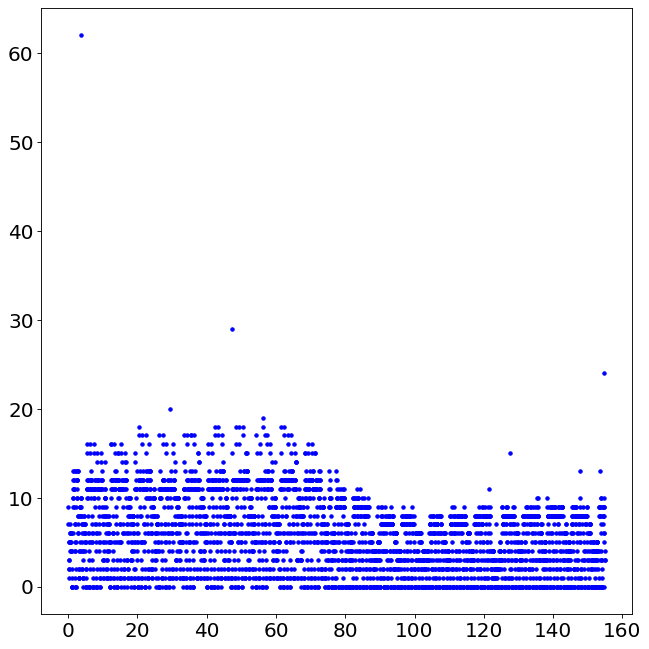

In [497]:
timestamps_in_days=(all_timestamps_in_sec-all_timestamps_in_sec[0])/60/60/24 # convert timestamp to days)
y_output_avg_vol_cars = np.extract(all_timestamps_in_sec,df_site_1.iloc[:,3]).astype(np.int64)

# plot extracted data
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(timestamps_in_days,y_output_avg_vol_cars, color='blue', marker='.'); plt.show()

In [498]:
#dd is trend or seasonality
#lag is number of points
#q is step size
def test_preds(q,dd,lag, plot):
    #q-step ahead prediction
    stride=1
    XX=y_output_avg_vol_cars[0:y_output_avg_vol_cars.size-q-lag*dd:stride]
    for i in range(1,lag):
        X=y_output_avg_vol_cars[i* dd:y_output_avg_vol_cars.size-q- (lag-i)*dd:stride]
        XX=np.column_stack((XX,X))
    yy=y_output_avg_vol_cars[lag* dd+q::stride]
    end_time_in_days=timestamps_in_days[lag* dd+q::stride]
    from sklearn.model_selection import train_test_split
    train, test = train_test_split(np.arange(0,yy.size),test_size=0.2)
    from sklearn.linear_model import Ridge
    # from sklearn.neighbors import KNeighborsRegressor
    # model = KNeighborsRegressor(n_neighbors =10).fit(XX[train], yy[train])
    model = Ridge(fit_intercept=False).fit(XX[train], yy[train])
    print(model.intercept_, model.coef_)
    if plot:
        y_pred = model.predict(XX)
        plt.scatter(timestamps_in_days, y_output_avg_vol_cars, color='black'); plt.scatter(end_time_in_days, y_pred, color='blue')
        plt.xlabel("time (days)"); plt.ylabel("#volume of cars")
        plt.legend(["training data","predictions"],loc='upper right')
        day=math.floor(24*60*60/time_sampling_interval) # number of samples per day
        plt.xlim(((lag*dd+q)/day,(lag*dd+q)/day+2))
        plt.show()

0.0 [0.23773033 0.0705995  0.27784346]


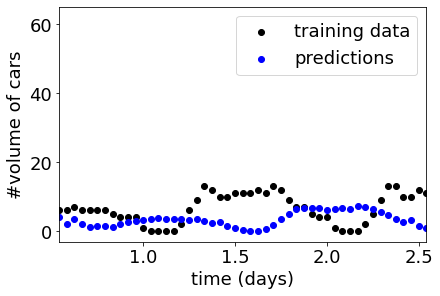

0.0 [0.32976791 0.25515529 0.35721052]


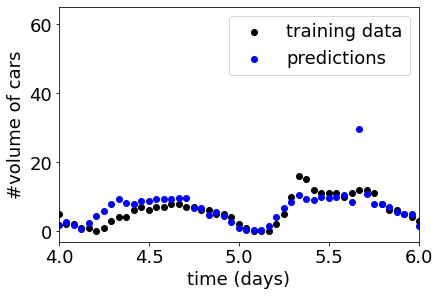

0.0 [0.03537782 0.27639025 0.58575983]


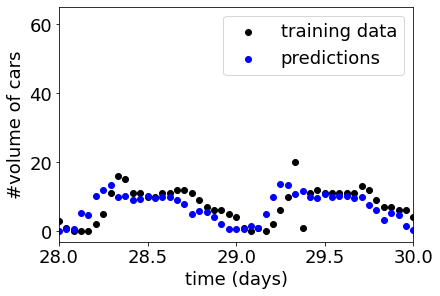

In [499]:
# prediction using short-term trend
plot=True
test_preds(q=10,dd=1,lag=3,plot=plot)

# # prediction using daily seasonality
d=math.floor(24*60*60/time_sampling_interval) # number of samples per day
test_preds(q=d,dd=d,lag=3,plot=plot)

# # # prediction using weekly seasonality
w=math.floor(7*24*60*60/time_sampling_interval) # number of samples per week
test_preds(q=w,dd=w,lag=3,plot=plot)

0.0 [-2.83924517e-04  2.35061047e-01  5.67288743e-01 -2.83924511e-04
  2.12041110e-02  2.21908056e-02 -5.42511084e-02  2.50123004e-02
  1.03149631e-01]


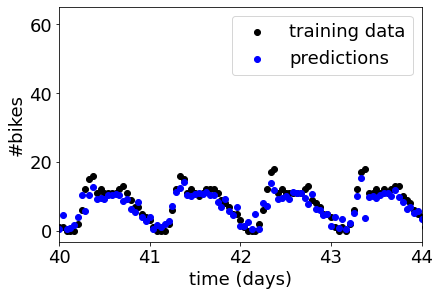

In [520]:
#putting it together
q=10
lag=3; stride=1
w=math.floor(7*24*60*60/time_sampling_interval) # number of samples per week
d=math.floor(24*60*60/time_sampling_interval) # number of samples per day
len = y_output_avg_vol_cars.size-w-lag*w-q
XX=y_output_avg_vol_cars[q:q+len:stride]
for i in range(1,lag):
    X=y_output_avg_vol_cars[i*w+q:i*w+q+len:stride]
    XX=np.column_stack((XX,X))
for i in range(0,lag):
    X=y_output_avg_vol_cars[i*d+q:i*d+q+len:stride]
    XX=np.column_stack((XX,X))
for i in range(0,lag):
    X=y_output_avg_vol_cars[i:i+len:stride]
    XX=np.column_stack((XX,X))
yy=y_output_avg_vol_cars[lag*w+w+q:lag*w+w+q+len:stride]
end_time_in_days=timestamps_in_days[lag*w+w+q:lag*w+w+q+len:stride]
from sklearn.model_selection import train_test_split
train, test = train_test_split(np.arange(0,yy.size),test_size=0.2)
#train = np.arange(0,yy.size)
from sklearn.linear_model import Ridge
model = Ridge(fit_intercept=False).fit(XX[train], yy[train])
print(model.intercept_, model.coef_)

if plot:
    y_pred = model.predict(XX)
    plt.scatter(timestamps_in_days, y_output_avg_vol_cars, color='black'); plt.scatter(end_time_in_days, y_pred, color='blue')
    plt.xlabel("time (days)"); plt.ylabel("#bikes")
    plt.legend(["training data","predictions"],loc='upper right')
    day=math.floor(24*60*60/time_sampling_interval) # number of samples per day
    plt.xlim((4*10,4*10+4))
    plt.show()


In [501]:
# TODO:
# Cross-Validation -kFold or timeseries split
# Using sites as features
# Different Model implementations
# Using weather features
# Include Collab Plots
# Evaluation
# Report